In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings


In [11]:
warnings.simplefilter(action='ignore')

In [12]:
# Import Time Series Data
locale = '/Users/bixbypeterson/desktop/WGU/D213/medical_time_series.csv'
dataset = pd.read_csv(locale)

In [13]:
#EDA - Analysis
# Get Shape of the data
print('Number of Rows: ', dataset.shape[0], '\n')
print('Number of Features: ', dataset.shape[1], '\n')

Number of Rows:  731 

Number of Features:  2 



In [14]:
# View first 5 rows of data
print(dataset.head(5))

   Day   Revenue
0    1  0.000000
1    2 -0.292356
2    3 -0.327772
3    4 -0.339987
4    5 -0.124888


In [15]:
# Check for presence of NULL and/or Duplicates
print('\nAny Null Values in Day: ', dataset.isnull().any()[0], '\n')
print('Any Null Values in Revenue: ', dataset.isnull().any()[0], '\n')
print('Any Duplications:', dataset.duplicated().any(), '\n')


Any Null Values in Day:  False 

Any Null Values in Revenue:  False 

Any Duplications: False 



In [16]:
# Create DateTime Field and set as Index
dataset['DateTime'] = list(pd.date_range(start=datetime(
    2019, 1, 1), periods=dataset.shape[0], freq='24H'))

dataset.set_index('DateTime', inplace=True)
dataset.index = pd.DatetimeIndex(dataset.index)
dataset.drop(columns = 'Day', inplace=True)


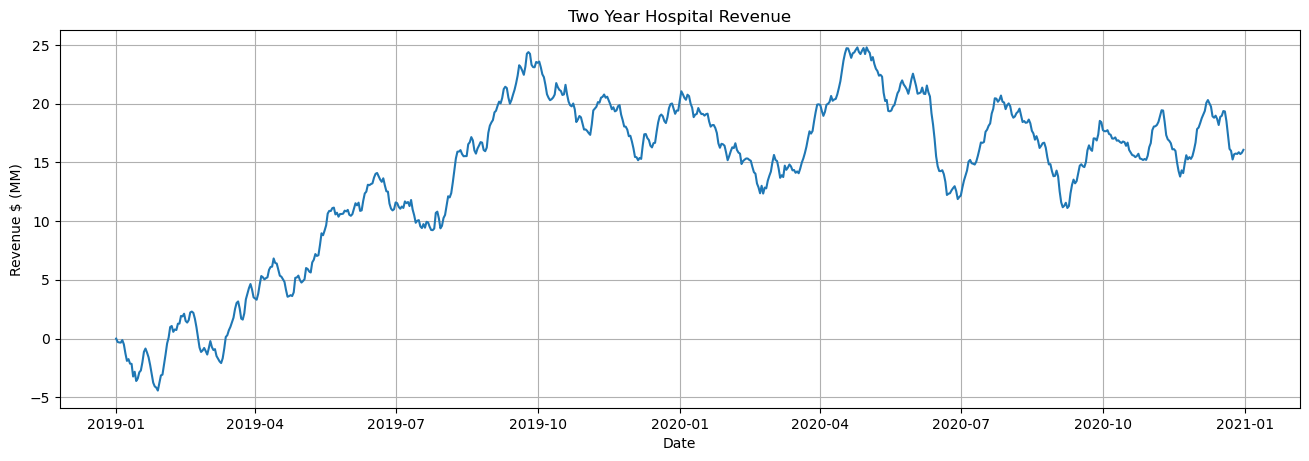

In [17]:
# Visualize Data
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(dataset.index, dataset['Revenue'])
plt.title('Two Year Hospital Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue $ (MM)')
plt.grid(True)
plt.show()

In [18]:
# Validate if initial dataset is Stationary using adfuller
results = adfuller(dataset['Revenue'])
print('P-value: ',results[1])
if results[1] <= 0.05:
    print('Data Set is Stationary, Reject NULL hypothesis\n')
    diff_df = dataset
else:
    print('Data is non-Stationary, Fail to reject NULL hypothesis\n')

    # Generate Stationary DataSet, using DIFF()
    diff_df = dataset.diff().dropna()
    
    # Reconfirm that data is now Stationary using adfuller
    results = adfuller(diff_df['Revenue'])
    print('P-value: ',results[1])
    if results[1] <= 0.05:
        print('Data Set is Stationary, Reject NULL hypothesis\n')
    else:
        print('Data is non-Stationary, Fail to reject NULL hypothesis\n')
        raise Exception('Data is non-Stationary, can not proceed')    

P-value:  0.19966400615064328
Data is non-Stationary, Fail to reject NULL hypothesis

P-value:  5.113206978840171e-30
Data Set is Stationary, Reject NULL hypothesis



In [19]:
# Split data into Train and Test sets
# Train Data - Sample 80%
med_train = diff_df.loc['2019-05-17':]
# med_train = diff_df.loc[:'2020-07-30']

# Test Data - Sample 20%
med_test = diff_df.loc[:'2019-05-16']
# med_test = diff_df.loc['2020-08-01':]

In [20]:
# Confirm train and test
print('Shape of Train data: ', med_train.shape[0], ' / ', round(med_train.shape[0] / diff_df.shape[0],2)*100,'%')
print('Shape of Test data: ', med_test.shape[0], ' / ', round(med_test.shape[0] / diff_df.shape[0],2)*100,'%')

Shape of Train data:  595  /  82.0 %
Shape of Test data:  135  /  18.0 %


In [21]:
# Export Clean / Train / Test Data Sets
med_train.to_csv('/Users/bixbypeterson/desktop/WGU/D213/Task 1 - Time Series/task_1_train_data.csv',sep=',',index=False)
med_test.to_csv('/Users/bixbypeterson/desktop/WGU/D213/Task 1 - Time Series/task_1_test_data.csv',sep=',',index=False)
diff_df.to_csv('/Users/bixbypeterson/desktop/WGU/D213/Task 1 - Time Series/task_1_clean_data.csv',sep=',',index=False)

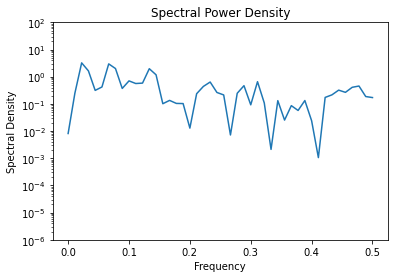

In [192]:
# # Spectral Density
f, Pxx_den = signal.periodogram(diff_df['Revenue'], window = 'triang', nfft=90)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Power Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

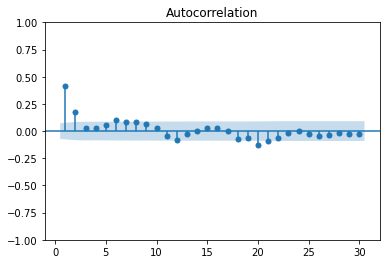

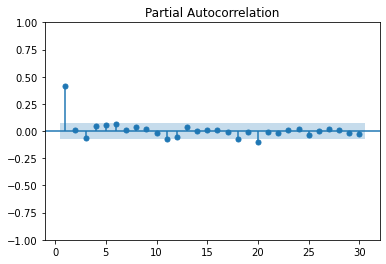

In [193]:
# Spectral Density shows spikes in the densities, confirming seasonality of data. 

#ACF / PCF to confirm Stationary Data
plot_acf(diff_df['Revenue'], lags=30, zero=False)
plt.show()

plot_pacf(diff_df['Revenue'], lags=30, zero=False)
plt.show()

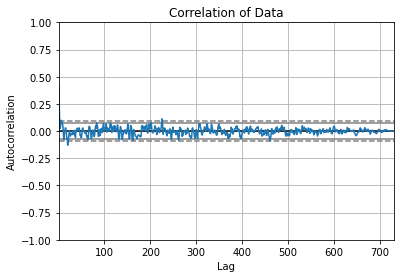

In [194]:
# View autocorrelation of data
plt.title('Correlation of Data')
autocorrelation_plot(diff_df.Revenue.tolist())
plt.show()

In [195]:
# Decomposition of Data
seas_decom = seasonal_decompose(dataset['Revenue'], period=60)

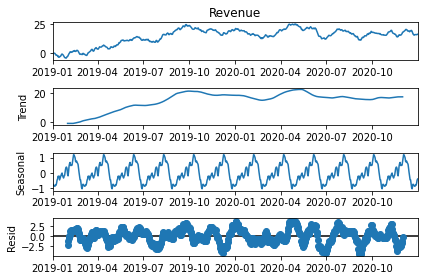

In [196]:
# Charting decompostion of the time series
seas_decom.plot()
plt.show()

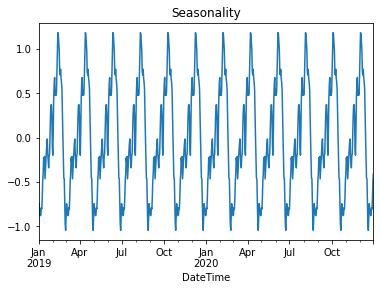

In [197]:
# Plot Seasonality
plt.title('Seasonality')
seas_decom.seasonal.plot()
plt.show()

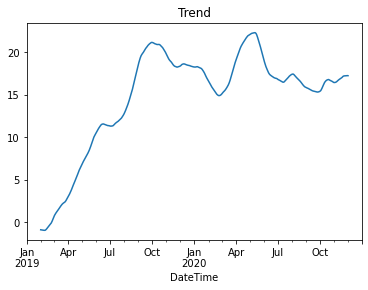

In [198]:
# Seasonality is detected, depicted by spikes and valleys in the data every ~3 months

# Plot Trend
plt.title('Trend')
seas_decom.trend.plot()
plt.show()

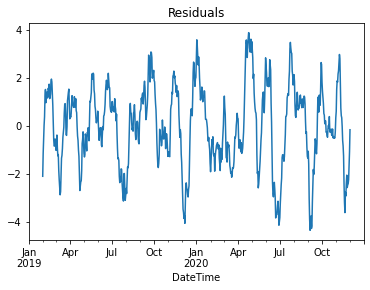

In [199]:
# Trend graphs depicts an increasing trend

# Plot Residuals
plt.title('Residuals')
seas_decom.resid.plot()
plt.show()

In [106]:
# Residual graph depicts no trend, which is expected for seasonal data

#Loop through a range of three (3) to find the best AIC
optimal_aic = np.inf
order = None
model = None
rnge = range(3)

for p in rnge:
    for q in rnge:
        for d in rnge:
            try:
                mdl = SARIMAX(med_train['Revenue'],order=(p,d,q),trend='c')
                outcome = mdl.fit(disp=False)
                aic = outcome.aic
                if aic < optimal_aic:
                    optimal_aic = aic
                    order = (p,d,q)
            except: 
                continue

print(f'\nBest AIC: {optimal_aic}\nOrder: {order}')


Best AIC: 712.8261523251881
Order: (1, 0, 0)


In [17]:
#Generate Model using auto-ARIMA and train data         
mdl = auto_arima(med_train['Revenue'], seasonal = True, stationary=True, m=90, d=1, D=1, start_p=1, start_q=1, max_p=2, max_q=2, max_P=2, max_Q=2, trace=True, error_action='ignore', supress_warnings=True)
print(mdl.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[90] intercept   : AIC=inf, Time=102.89 sec
 ARIMA(0,0,0)(0,0,0)[90] intercept   : AIC=817.391, Time=0.18 sec
 ARIMA(1,0,0)(1,0,0)[90] intercept   : AIC=714.255, Time=22.26 sec
 ARIMA(0,0,1)(0,0,1)[90] intercept   : AIC=730.767, Time=76.15 sec
 ARIMA(0,0,0)(0,0,0)[90]             : AIC=815.736, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[90] intercept   : AIC=712.826, Time=0.14 sec
 ARIMA(1,0,0)(0,0,1)[90] intercept   : AIC=714.166, Time=20.41 sec
 ARIMA(1,0,0)(1,0,1)[90] intercept   : AIC=inf, Time=88.16 sec
 ARIMA(2,0,0)(0,0,0)[90] intercept   : AIC=714.824, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[90] intercept   : AIC=714.824, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[90] intercept   : AIC=729.576, Time=0.35 sec
 ARIMA(2,0,1)(0,0,0)[90] intercept   : AIC=716.172, Time=1.33 sec
 ARIMA(1,0,0)(0,0,0)[90]             : AIC=710.993, Time=0.28 sec
 ARIMA(1,0,0)(1,0,0)[90]             : AIC=712.428, Time=6.37 sec
 ARIMA(1,0,0)(0,0,1)[90]           

In [23]:
#Time Series Model
mdl = SARIMAX(med_train['Revenue'], order=(1,0,0), seasonal_order = (0,0,0,90) )
outcome = mdl.fit(disp=False)
print(outcome.summary())
print(outcome.params)

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  595
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -353.496
Date:                Sat, 06 Aug 2022   AIC                            710.993
Time:                        13:20:14   BIC                            719.770
Sample:                    05-17-2019   HQIC                           714.411
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4053      0.037     10.845      0.000       0.332       0.479
sigma2         0.1921      0.012     16.549      0.000       0.169       0.215
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [26]:
#Find Mean Absolute Error
print(f'\nMean Absolute Error: {np.mean(np.abs(outcome.resid))}\n')



Mean Absolute Error: 0.3524194483538728



In [27]:
#Generate Predicitions
prediction = outcome.get_prediction()

In [28]:
#Get Prediction Mean
prediction_mean = prediction.predicted_mean

In [29]:
#Obtain Confidence Intervals
confidence_int = prediction.conf_int()

In [30]:
#Select Lower / Upper Confidence Intervals
lower_limits = confidence_int.loc[:,'lower Revenue']
upper_limits = confidence_int.loc[:,'upper Revenue']

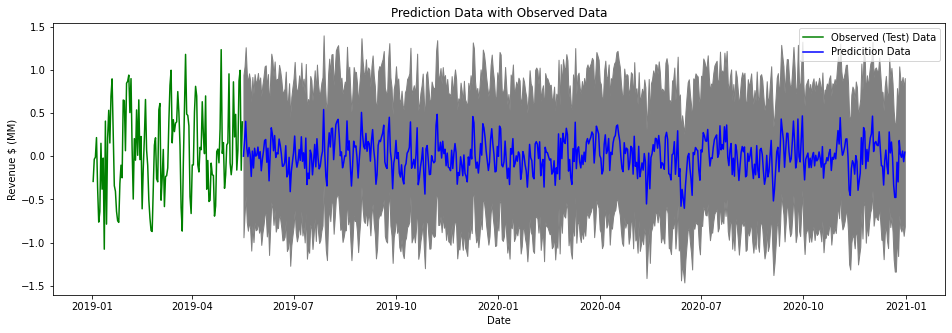

In [31]:
# Plot Predicition and Test Data with labels and legend
plt.figure(figsize=(16,5))
plt.plot(med_test.index, med_test['Revenue'], label = 'Observed (Test) Data', color = 'g')
plt.plot(prediction_mean.index, prediction_mean, color='b', label='Predicition Data')
plt.fill_between(lower_limits.index,lower_limits,upper_limits, color='grey')
plt.title('Prediction Data with Observed Data')
plt.xlabel('Date')
plt.ylabel('Revenue $ (MM)')
plt.legend()
plt.show()

In [32]:
# Generate Forecast
# Forecasting for 90 days / 3 months / 1 Quarter
forecast = outcome.get_forecast(steps = 90)
mean_forecast = forecast.predicted_mean

In [33]:
# Generate Confidence levels for Forecast Predicition
forecast_conf_intervals = forecast.conf_int()

# Get Upper / Lower Confidence levels
lower_level = forecast_conf_intervals.loc[:,'lower Revenue']
upper_level = forecast_conf_intervals.loc[:,'upper Revenue']

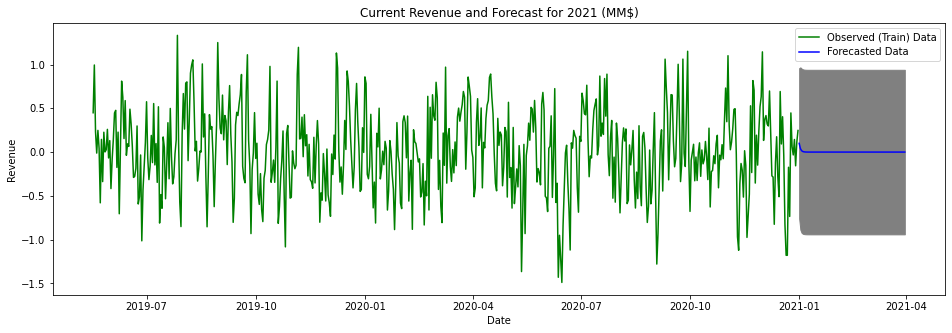

In [36]:
# Plot Forecasted Revenue
plt.figure(figsize=(16,5))
plt.plot(med_train.index, med_train['Revenue'], color = 'g', label = 'Observed (Train) Data')
plt.plot(mean_forecast.index, mean_forecast, color = 'b', label = 'Forecasted Data') # Forecasted plot
plt.fill_between(lower_level.index, lower_level, upper_level, color = 'grey') # Shaded confidence area on plot
# Set Plot properties
plt.title('Current Revenue and Forecast for 2021 (MM$)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()